### Task 1: Denoising AutoEncoder

The below cell contain the code of the model dataset etc. For analysis and interpretation please skip to the section *Problem*.

In [1]:
# Required imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import copy
import os
from skimage.filters.rank import entropy
from skimage.morphology import disk
import albumentations as A
plt.style.use('ggplot')
%matplotlib inline

def PSNR(img1, img2):
    """Calculate Peak Signal to Noise Ratio between two images
    Args:
        img1, img2: Input images with pixel values in range [0, 255]
    Returns:
        float: PSNR value in decibels
    """
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

class NoiseDataset(Dataset):
    """Custom PyTorch Dataset for image denoising
    
    Creates pairs of clean and noisy grayscale images by adding Gaussian noise
    to clean images from a specified directory.
    """
    def __init__(self, data_path: str, sigma: int=60):
        """
        Args:
            data_path: Directory containing clean PNG images
            sigma: Standard deviation of Gaussian noise to add
        """
        self.sigma = sigma
        self.data_path = data_path
        
        # Get list of PNG images in directory
        self.img_names = [n for n in os.listdir(data_path) if n.endswith('.png')]
        
        # Define image transformations: convert to tensor and normalize
        self.transformation = transforms.Compose([   
            transforms.ToTensor(),   
            transforms.Normalize(mean=0., std=1.),            
        ]) 

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        """Get a pair of clean and noisy images
        
        Returns:
            tuple: (clean_image, noisy_image) both as normalized tensors
        """
        # Load image and convert from BGR to RGB
        img = cv.imread(
            os.path.join(self.data_path, self.img_names[idx])
        )[:, :, ::-1]
        
        # Generate clean and noisy image pair
        img_gray, img_noised = self._get_noisy_img(img, sigma=self.sigma)
        
        # Apply transformations
        img_gray = self.transformation(img_gray)
        img_noised = self.transformation(img_noised)
        return img_gray, img_noised
    
    @staticmethod
    def _get_noisy_img(img, sigma=60):
        """Add Gaussian noise to an image
        
        Args:
            img: Input RGB image
            sigma: Standard deviation of noise
            
        Returns:
            tuple: (grayscale_image, noisy_grayscale_image)
        """
        # Convert to grayscale
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Generate and add noise
        noise = np.random.normal(0, sigma, img_gray.shape)
        img_noised = img_gray + noise
        
        # Convert to uint8 and ensure pixel values are in [0, 255]
        img_gray = (img_gray).astype(np.uint8)
        img_noised = (np.clip(img_noised, 0, 255)).astype(np.uint8)
        
        return img_gray, img_noised

class DenoisingAutoEncoder(nn.Module):
    """Convolutional Autoencoder for image denoising
    
    Architecture consists of an encoder that downsamples the image and a decoder
    that reconstructs the clean image. Uses convolutions, batch normalization,
    and ReLU activations.
    """
    def __init__(self, features: int=8):
        """
        Args:
            features: Base number of convolutional filters (multiplied in deeper layers)
        """
        super(DenoisingAutoEncoder, self).__init__()
        
        # Encoder: series of Conv2d + BatchNorm + ReLU blocks
        # Progressively increases number of features and reduces spatial dimensions
        self.encoder = nn.Sequential(
            nn.Conv2d(1, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.Conv2d(features, features*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),
            nn.Conv2d(features*2, features*4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            nn.Conv2d(features*4, features*4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder: a Transposed 2D Conv then series of Conv2d + BatchNorm + ReLU blocks
        # Progressively decreases features and increases spatial dimensions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features*4, features*4, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            nn.Conv2d(features*4, features*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),
            nn.Conv2d(features*2, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.Conv2d(features, 1, kernel_size=3, padding=1, bias=False),
        )

        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """Forward pass through the autoencoder
        
        Args:
            x: Input noisy image tensor
            
        Returns:
            tensor: Reconstructed clean image
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train_model(model, loss_fn, eval_criteria, train_loader, test_loader, optimizer, n_epochs, device):
    """Train the denoising autoencoder
    
    Args:
        model: DenoisingAutoEncoder instance
        loss_fn: Loss function (e.g. MSE)
        eval_criteria: Evaluation metric (e.g. PSNR)
        train_loader: DataLoader for training data
        test_loader: DataLoader for validation data
        optimizer: Optimization algorithm
        n_epochs: Number of training epochs
        device: Device to train on (CPU/GPU)
        
    Returns:
        tuple: (best_model, performance_metrics, best_psnr)
    """
    performace = defaultdict(list)
    
    for epoch in tqdm(range(n_epochs)):
        # Initialize metrics
        total_train_loss = 0
        total_val_loss = 0
        total_train_psnr = 0
        total_val_psnr = 0
        best_psnr = 0
        best_model = copy.deepcopy(model)
        
        # Training phase
        model.train()
        for _, (images, noisy_batch) in enumerate(train_loader):
            images = images.to(device)
            noisy_batch = noisy_batch.to(device)
            
            # Forward pass
            output = model(noisy_batch)
            loss = loss_fn(images, output)
            total_train_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate PSNR
            psnr = eval_criteria(images, output)
            total_train_psnr += psnr.item()
            
        # Store training metrics
        performace['train_loss'].append(total_train_loss/len(train_loader))
        performace['train_psnr'].append(total_train_psnr/len(train_loader))
        
        # Validation phase
        model.eval()
        for _, (images, noisy_batch) in enumerate(test_loader):
            with torch.no_grad():
                images = images.to(device)
                noisy_batch = noisy_batch.to(device)
                
                output = model(noisy_batch)
                loss = loss_fn(images, output)
                total_val_loss += loss.item()
                
                psnr = eval_criteria(images, output)
                total_val_psnr += psnr.item()

        # Store validation metrics
        performace['val_loss'].append(total_val_loss/len(test_loader))
        performace['val_psnr'].append(total_val_psnr/len(test_loader))

        # Choose best model based on validation PSNR
        if total_val_psnr/len(test_loader) > best_psnr:
            best_psnr = total_val_psnr/len(test_loader)
            best_model = copy.deepcopy(model)

    return best_model, performace, best_psnr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
  data = fetch_version_info()


In [112]:
data = NoiseDataset(data_path="./data_denoising/train/", sigma = 20)
dataloader = DataLoader(data, batch_size=data.__len__())
for i, (images, noisy_batch) in enumerate(dataloader):
    mean = images.mean()
    std = images.std()

#### Problem

In real world scenario, images are mostly corrupted, by noise for example. The corruption is often introduced by the equipement (e.g camera sensors). \
In the denoising problem, the image is corrupted by a noise, e.g gaussian noise. 

The problem can be formulated as follows: 

$\tilde{I} = I  + n  \quad \text{where:}$
$$\tilde{I} \in\mathbb{R}^{M\times N} \quad \text{is the noisy image}$$
$$\text{and} \quad  I \in\mathbb{R}^{M\times N} \quad \text{is the original image}$$
$$\text{and} \quad n \sim {\mathcal{N}}(\mu, \sigma) \quad \text{is the noise}$$


#### Adding Meaningful Maximum amout of noise

To generate a noisy image, noise is first sampled from a normal distribution with a mean of zero and variance $\sigma$, which is then added to the image. The amount of noise introduced depends on the value of $\sigma$: a larger $\sigma$ results in more noise, producing a highly noisy image.

The function _get_noisy_img in the NoisyDataset class handles the process of adding noise to the image. After applying the noise, the pixel values are clipped to remain within the valid range of $[0, 255]$.

To consider a meaningful Maximum amount of noise, we need to find a suitable value of $\sigma$ that achieves this balance.
However, I could not find a mathematical intuition that leads to identifying such value of $\sigma$. 

So, we use the heuristic elbow method to find the $\sigma$ after which the value of mean square error is not highly changing. Then, we visually inspect the resulting noise level to ensure it is meaningful. If the noise appears excessive, a lower $\sigma$ value is chosen.

Text(0.5, 1.0, 'MSE Across Different Sigma')

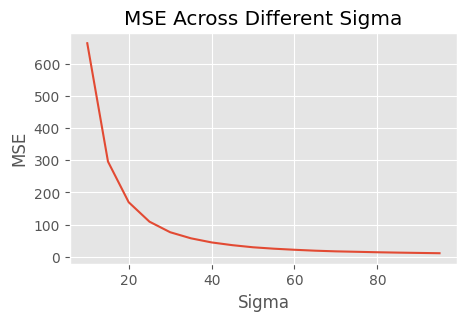

In [142]:
data_path = "./data_denoising/train/" # noiseless training images
sigmas = [i for i in range(10, 100, 5)] # Define a range of sigma
mse_values = []

# looping over the sigmas and compute the mean square error between the image and the noisy ones
for sigma in sigmas : 
        data = NoiseDataset(data_path=data_path, sigma = sigma)
        dataloader = DataLoader(data, batch_size=data.__len__())
        for i, (images, noisy_batch) in enumerate(dataloader):
                mse = 1/F.mse_loss(images, noisy_batch)
                mse_values.append(mse.item())
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(sigmas, mse_values)
plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.title('MSE Across Different Sigma')


From the graph below, we can see that after the elbow correspending to $\sigma = 20$ , we have the mean square error is high and it is not changing a lot after this value. So we can consider this value and inspect visually the noise added by it.

From the graph below, we observe that the elbow point corresponds to $\sigma = 20$. Beyond this value, the mean squared error (MSE) remains high but shows minimal changes. Therefore, we can consider $\sigma = 20$ as a potential candidate and visually inspect the noise it introduces.

Using $\sigma = 20$, the images are noisy, but the primary object in the image are visually identifiable.

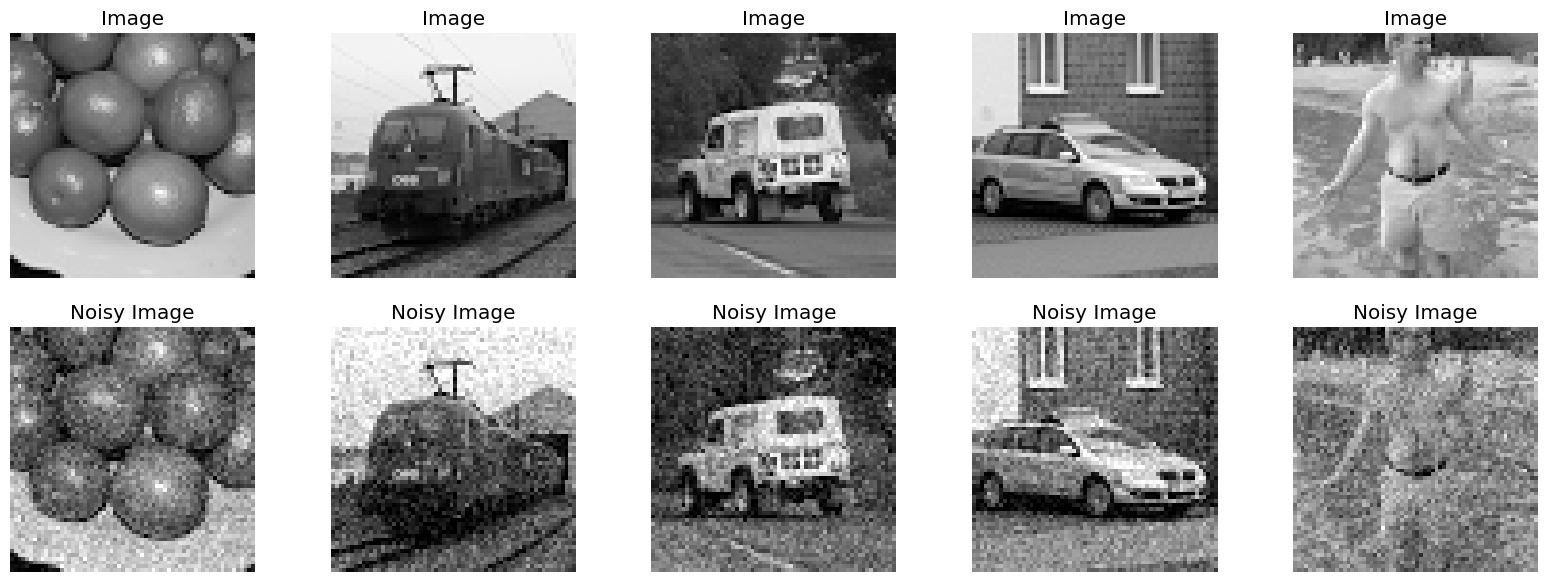

In [143]:
data = NoiseDataset("./data_denoising/train/", sigma = 20)
dataloader = DataLoader(data, batch_size=1, shuffle=False)
plt.rcParams["figure.figsize"] = (20,7)
fig, axis = plt.subplots(2, 5)
for i, (images, noisy_batch) in enumerate(dataloader):
    if i<5:
        axis[0, i-5].imshow(images[0, 0,...], cmap='gray') 
        axis[0, i-5].set_title('Image')
        axis[0, i-5].axis('off')
        axis[1, i-5].imshow(noisy_batch[0, 0,...], cmap='gray') 
        axis[1, i].set_title('Noisy Image')
        axis[1, i].axis('off')

### Model Architecture and Training


The architecture used is an autoencoder.In the encoder, there are four 2D convolutional layers for learning representations of the noisy image, each followed by Batch Normalization (BatchNorm) and a ReLU activation function. After the final convolutional layer, a max pooling operation is applied for downsampling.

In the decoder, a single 2D transposed convolutional layer is used to upsample the image, followed by a ReLU activation and a BatchNorm layer. This is followed by three 2D convolutional layers to reduce the number of features and reconstruct the denoised image.

Various modifications to this architecture were tested, such as adding more layers, downsampling and upsampling strategies, but these adjustments led to worse results. No architectures incorporating Linear layers were tested.

To train the model, we minimize the mean squared error loss function ($MSE$) over the training data$. 
$$L(I, f(\tilde{I})) = MSE(I, f(\tilde{I})) =\frac{1}{m}\sum_{i=1}^{m} ||I_{i} - f(\tilde{I_{i}})||^{2}_{2}$$

To evaluate and choose the good the model , we use as evaluation criteria the PSNR 
the Peak Signal to Noise Ratio (PSNR) in decibels (dB) defined as:
$$ PSNR=10\log_{10}\frac{255^2}{MSE}, $$
where $MSE$ is the mean squared error between the denoised image and the noiseless one.


**Data Preparation**


The training dataset will be handled by a torch `Dataset` and `DataLoader` , which combines a dataset and a sampler,
Where the `Dataset` stores the samples and their labels and the `DataLoader` provide an iterator around the data `Dataset` to access the samples easily.
For the denoising task the data consists of pairs of noisy/noiseless image extracted from a set of images.

The NoiseDataset class takes the path of a directory containing noiseless images and a $simga$ to create samples of noisy/noiseless image. the function 
```python 
def __get_noisy_img(img, sigma=60):
``` 
in the NoiseDataset class transform the noiseless image to noisy image by adding a gaussian noise of variance sigma . 


In [2]:
batch_size = 5
training_data = NoiseDataset(data_path = "./data_denoising/train/", sigma = 20)
test_data = NoiseDataset(data_path = "./data_denoising/test/", sigma = 20)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Training Loop**

In the training loop the network processes mini-batches of training images, apply the model then compares the results against the desired outputs (with the loss). Errors are then back-propagated through the system for the computation of the gradient of the loss with respect to the parameters of the network. This gradient will be used by an optimizer to adjust the the parameters for the next iteration.

To summarize the steps of the learning process:

1. *For each epoch*
    1. *For each minibatch*
        1. *Apply forward model to compute the output*
        2. *Compute the loss (MSE) on the batch and evaluation critertia (PSNR)*
        3. *Backpropagate to compute gradients of the loss w.r.t. the learnable model parameters*
        4. *Optimizer updates the model parameters using the gradients computed above*
    2. *For each minibatch*
        1. *Apply forward model to compute the output*
        2. *Compute the loss (MSE) on the batch and evaluation critertia (PSNR)*


The function `trainmodel` defined before implements the above algorithm.

We will use the Adam optimize with a learning rate of $10^{-3}$

In [117]:
# Hyperparameters 
learning_rate = 1e-3
n_epochs = 2500
device = 'cuda' if torch.cuda.is_available() else 'mps' 
loss_fn = nn.MSELoss()
model = DenoisingAutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
eval_criteria = PSNR

model, performace, best_psnr = train_model(model, loss_fn, eval_criteria, train_loader, test_loader, optimizer, n_epochs, device)

100%|██████████| 2500/2500 [01:46<00:00, 23.54it/s]


### Model Evaluation 

**Quantitative Evaluation**

We plot the evolution of the loss function and the PSNR on the training and test set. 

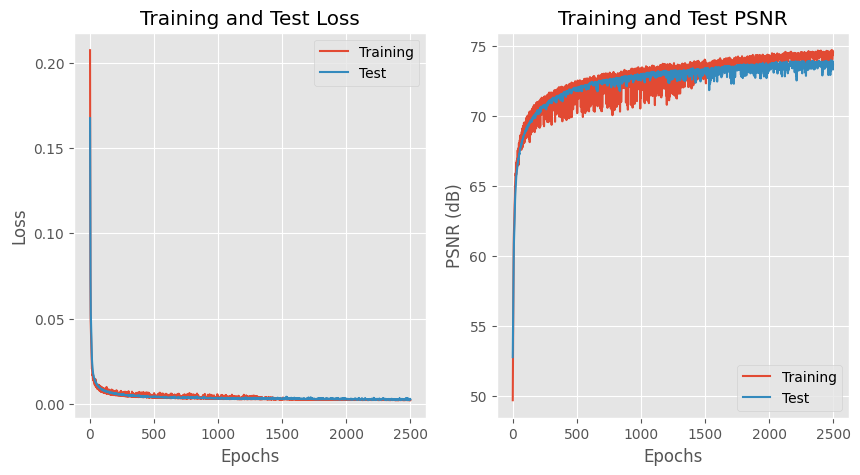

PSNR value on the test set of the model 73.681 dB


In [137]:
plt.rcParams["figure.figsize"] = (10,5)
fig, axis = plt.subplots(1, 2)
axis = axis.flatten()
epochs = [i for i in range(n_epochs)]
n = 3
axis[0].plot(epochs[n:], performace['train_loss'][n:])
axis[0].plot(epochs[n:], performace['val_loss'][n:])
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_title('Training and Test Loss')
axis[0].legend(['Training', 'Test'])
axis[1].plot(epochs, performace['train_psnr'])
axis[1].plot(epochs, performace['val_psnr'])
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('PSNR (dB)')
axis[1].set_title('Training and Test PSNR')
axis[1].legend(['Training', 'Test'])

plt.show()
print(f'PSNR value on the test set of the model {round(best_psnr, 3)} dB')

The train and test losses they are highly correlated but we don't have yet a convergence. This could be verified by zooming on the curve of the loss by changing the parameter *n* in the code below. But, with using a higher number of epochs because while experimenting with higher number of epochs (more than 5000), an overfitting has occured. Some techniques could be tested to avoid this phenomena such as regularization, dropout or play with the model architecture. So sad that because of my availabilities, I could not afford to much time for this.

The PSNR value increases, as higher PSNR value means better model performance. Notably, the PSNR of the best model is 73.681 dB which is quite good. 

We took The PSNR and loss curves display oscillations, likely due to the small batch size of 5, which may introduce perturbations in the computation of the total loss.

**Qualitative Evaluation**

In [151]:
def qualitative_evaluation(model, data_path = "./data_denoising/train/", sigma = 20):
    data = NoiseDataset(data_path, sigma)
    dataloader = DataLoader(data, batch_size=1, shuffle=False)
    denoised_images =  []
    for i, (images, noisy_batch) in enumerate(dataloader):
            with torch.no_grad():
                # inference
                output = model(noisy_batch.to(device))
                denoised_images.append(output)

    plt.rcParams["figure.figsize"] = (20,7)
    fig, axis = plt.subplots(3, 10)
    for i, (images, noisy_batch) in enumerate(dataloader):
        if i < 10:
            axis[0, i-10].imshow(images.detach().cpu()[0, 0,...], cmap='gray') 
            axis[0, i-10].set_title('Image')
            axis[0, i-10].axis('off')
            axis[1, i-10].imshow(noisy_batch.detach().cpu()[0, 0,...], cmap='gray')
            axis[1, i-10].set_title('Noisy')
            axis[1, i-10].axis('off')
            axis[2, i-10].imshow(denoised_images[i].detach().cpu()[0, 0,...], cmap='gray')
            axis[2, i-10].set_title('Denoised')
            axis[2, i-10].axis('off') 

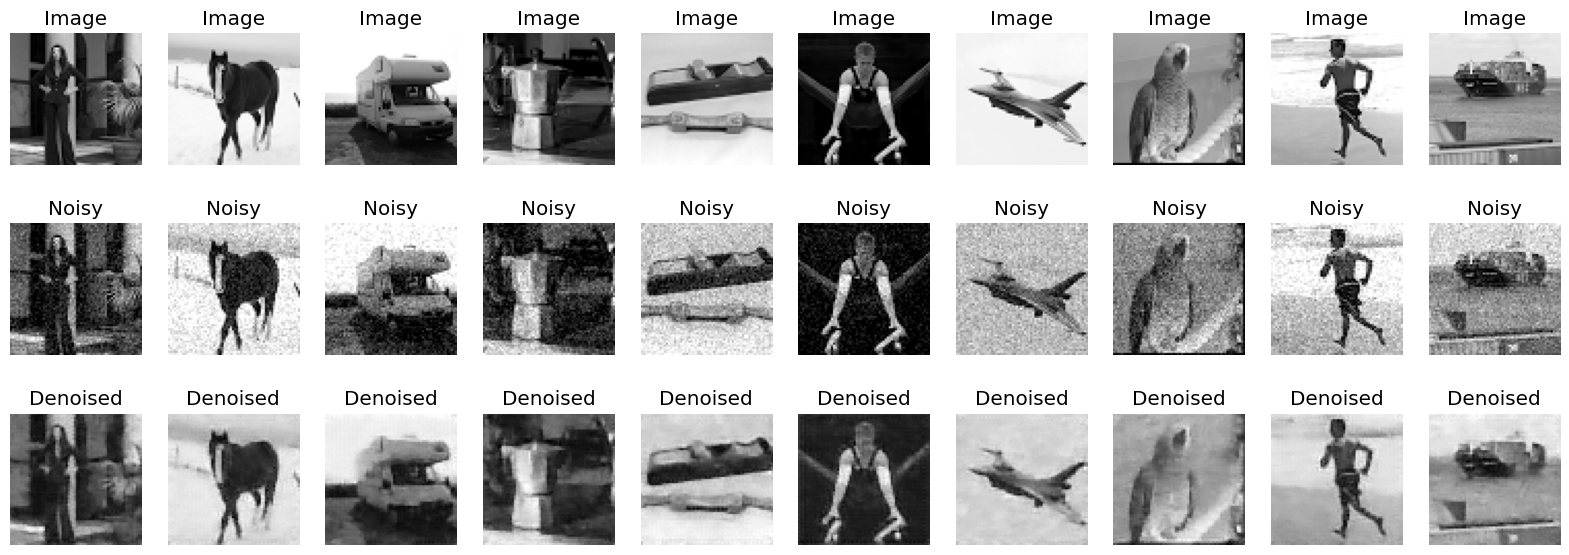

In [152]:
test_sigma = 20
qualitative_evaluation(model, data_path = "./data_denoising/test/", sigma = test_sigma)

Qualitatively, the restored images show a reduction in noise while preserving the structural integrity of objects, such as in the images of the horse or the men. However, some finer details appear lost or blurred ,such as in the case of the ship or the moka pot. In certain cases, traces of noise are still present, 

### Robusteness to the different Sigmas

We will evaluate the model by measuring the PSNR on the test set noised by different values of $\sigma$ given that the model is trained on a $\sigma_{model}$ = 20.

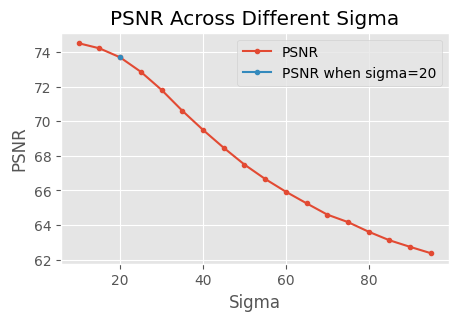

In [155]:
data_path = "./data_denoising/test/"
sigmas = [i for i in range(10, 100, 5)]
mse_values = []
psnr_values = []
for sigma in sigmas : 
        data = NoiseDataset(data_path=data_path, sigma = sigma)
        dataloader = DataLoader(data, batch_size=data.__len__())
        for i, (images, noisy_batch) in enumerate(dataloader):
                with torch.no_grad():
                    # inference
                    output = model(noisy_batch.to(device))
                    mse = 1/F.mse_loss(images.to(device), output)
                    psnr = PSNR(images.to(device), output)
                    mse_values.append(mse.item())
                    psnr_values.append(psnr.item())


plt.rcParams["figure.figsize"] = (5,3)
plt.plot(sigmas, psnr_values, '.-')
plt.plot([20], [psnr_values[2]], '.-')
plt.xlabel('Sigma')
plt.ylabel('PSNR')
plt.title('PSNR Across Different Sigma')
plt.legend(['PSNR', 'PSNR when sigma=20'])

The curve illustrates the evolution of PSNR with respect to sigma. The results are generally reasonable: for $\sigma$ values lower than $\sigma_{model}$ = 20 , the PSNR is slightly higher than that of the model trained with .

However, as $\sigma$  increases, the PSNR begins to decrease. This occurs because higher $\sigma$  values introduce more noise into the image, making it more challenging for the model to perform effective denoising.

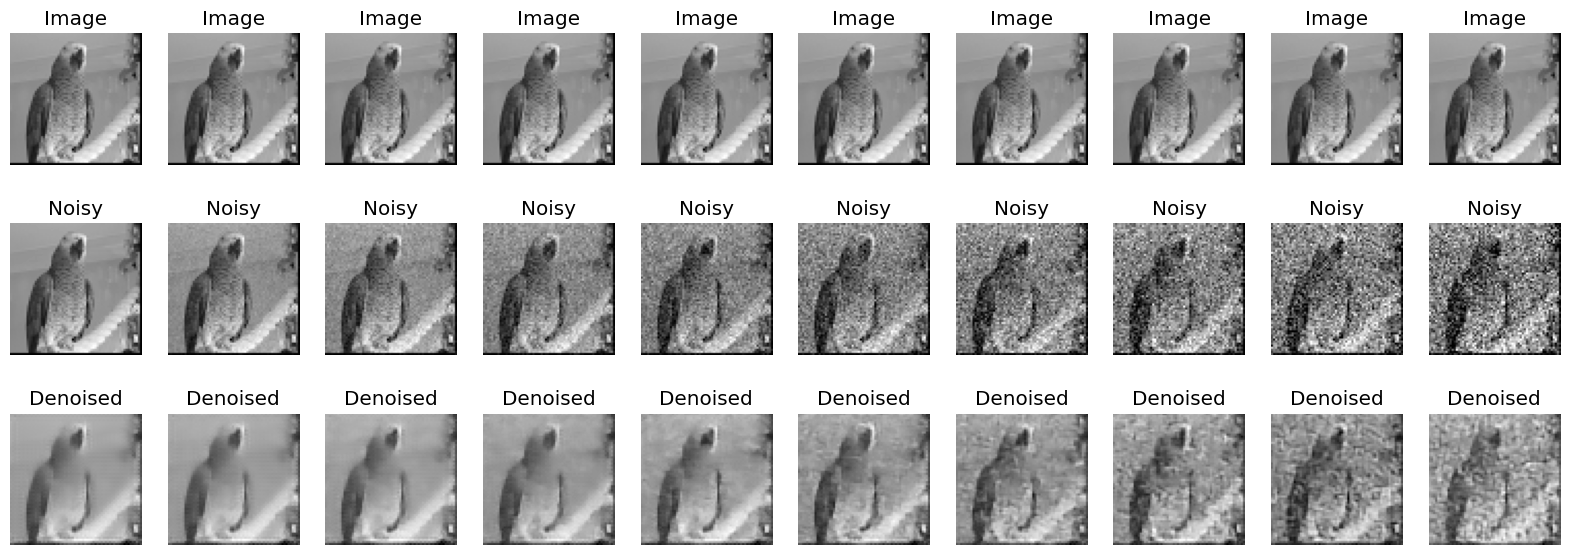

In [156]:
def get_noisy_img(img, sigma=60):
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_gray = img_gray
        noise = np.random.normal(0, sigma, img_gray.shape)
        img_noised = img_gray + noise
        return (img_gray/255.).astype(np.float32), (np.clip(img_noised, 0, 255)/255.).astype(np.float32)

img_path = "./data_denoising/test/00782.png"
img = cv.imread(img_path)[:, :, ::-1] 
sigmas = [i for i in range(0, 50, 5)]
noisy_img = []
restored_img = []

for sigma in sigmas : 

        img_gray, img_noisy = get_noisy_img(img, sigma=sigma)
        with torch.no_grad():
                # inference
                output = model(torch.Tensor(img_noisy).to(device).unsqueeze(0).unsqueeze(0))
                noisy_img.append(img_noisy)
                restored_img.append(output.cpu().numpy())


plt.rcParams["figure.figsize"] = (20,7)
fig, axis = plt.subplots(3, 10)

for i, r_img in enumerate(restored_img):
        if i < 10:
            axis[0, i-10].imshow(img_gray, cmap='gray') 
            axis[0, i-10].set_title('Image')
            axis[0, i-10].axis('off')
            axis[1, i-10].imshow(noisy_img[i], cmap='gray')
            axis[1, i-10].set_title('Noisy')
            axis[1, i-10].axis('off')
            axis[2, i-10].imshow(restored_img[i].squeeze(0).squeeze(0), cmap='gray')
            axis[2, i-10].set_title('Denoised')
            axis[2, i-10].axis('off') 

As previously observed, higher sigma values introduce more noise, which tends to persist in the restored image. On the other hand, for sigma values lower than $\sigma_{model}$ = 20, the restored images appear oversmoothed and blurry. This effect is particularly noticeable when no noise is present in the input image, resulting in certain regions becoming blurred.

Maybe that the model might act like a stack of Gaussian filters. When no noise is introduced, the filtering effect could lead to oversmoothing, thereby reducing the sharpness of the original image.

### VAE 

In [42]:
class DenoisingVAE(nn.Module):
    def __init__(self, features = 8, latent_dim= 128):
        super(DenoisingVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.Conv2d(features, features*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),
            nn.Conv2d(features*2, features*4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            nn.Conv2d(features*4, features*4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_mu = nn.Conv2d(features*4, latent_dim, kernel_size=1, padding=0, bias=False)
        self.conv_log_var = nn.Conv2d(features*4, latent_dim, kernel_size=1, padding=0, bias=False)
        # Decoder: a Transposed 2D Conv then series of Conv2d + BatchNorm + ReLU blocks
        # Progressively decreases features and increases spatial dimensions
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, features*4, kernel_size=1, padding=0, bias=False), 
            nn.ConvTranspose2d(features*4, features*4, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),
            nn.Conv2d(features*4, features*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),
            nn.Conv2d(features*2, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.Conv2d(features, 1, kernel_size=3, padding=1, bias=False),
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z
    
    def forward(self, x):
        (B, C, H, W) = x.shape

        enc_x = self.encoder(x)
        mean = self.conv_mu(enc_x)
        logvar  = self.conv_log_var(enc_x)
        if self.training:
            z = self.reparameterization(mean, logvar)
        else:
            z = mean
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.MSELoss()(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

def train_vae_model(model, 
                    loss_fn, 
                    eval_criteria, 
                    train_loader, 
                    test_loader, 
                    optimizer, 
                    n_epochs, 
                    device
    ):
    """Train the denoising autoencoder
    
    Args:
        model: DenoisingAutoEncoder instance
        loss_fn: Loss function (e.g. MSE)
        eval_criteria: Evaluation metric (e.g. PSNR)
        train_loader: DataLoader for training data
        test_loader: DataLoader for validation data
        optimizer: Optimization algorithm
        n_epochs: Number of training epochs
        device: Device to train on (CPU/GPU)
        
    Returns:
        tuple: (best_model, performance_metrics, best_psnr)
    """
    performace = defaultdict(list)
    
    for epoch in tqdm(range(n_epochs)):
        # Initialize metrics
        total_train_loss = 0
        total_val_loss = 0
        total_train_psnr = 0
        total_val_psnr = 0
        best_psnr = 0
        best_model = copy.deepcopy(model)
        
        # Training phase
        model.train()
        for _, (images, noisy_batch) in enumerate(train_loader):
            images = images.to(device)
            noisy_batch = noisy_batch.to(device)
            
            # Forward pass
            output, mean, logvar = model(noisy_batch)
            loss = loss_fn(images, output, mean, logvar)
            total_train_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate PSNR
            psnr = eval_criteria(images, output)
            total_train_psnr += psnr.item()
            
        # Store training metrics
        performace['train_loss'].append(total_train_loss/len(train_loader))
        performace['train_psnr'].append(total_train_psnr/len(train_loader))
        
        # Validation phase
        model.eval()
        for _, (images, noisy_batch) in enumerate(test_loader):
            with torch.no_grad():
                images = images.to(device)
                noisy_batch = noisy_batch.to(device)
                
                output, mean, logvar = model(noisy_batch)
                loss = loss_fn(images, output, mean, logvar)
                total_val_loss += loss.item()
                
                psnr = eval_criteria(images, output)
                total_val_psnr += psnr.item()

        # Store validation metrics
        performace['val_loss'].append(total_val_loss/len(test_loader))
        performace['val_psnr'].append(total_val_psnr/len(test_loader))

        # Choose best model based on validation PSNR
        if total_val_psnr/len(test_loader) > best_psnr:
            best_psnr = total_val_psnr/len(test_loader)
            best_model = copy.deepcopy(model)

    return best_model, performace, best_psnr

In [43]:
# Hyperparameters 
learning_rate = 1e-3
n_epochs = 2500
device = 'cuda' if torch.cuda.is_available() else 'mps' 
loss_fn = loss_function
model = DenoisingVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
eval_criteria = PSNR

model, performace, best_psnr = train_vae_model(model, loss_fn, eval_criteria, train_loader, test_loader, optimizer, n_epochs, device)

100%|██████████| 2500/2500 [01:41<00:00, 24.69it/s]


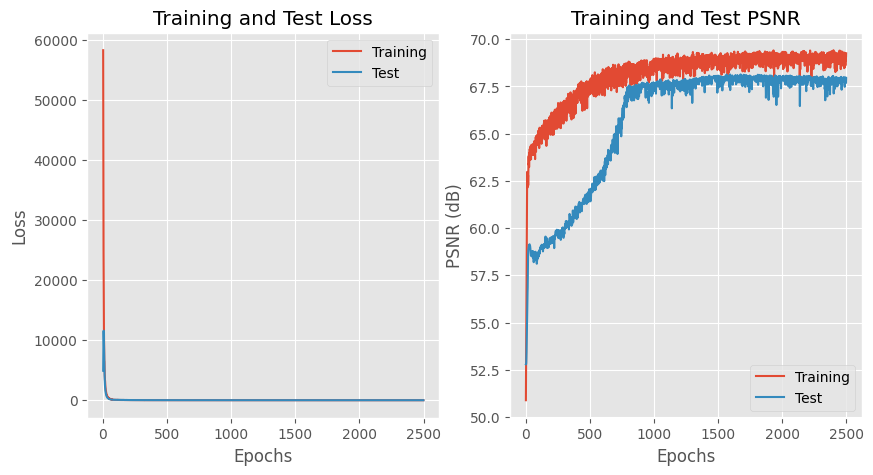

PSNR value on the test set of the model 67.935 dB


In [44]:
plt.rcParams["figure.figsize"] = (10,5)
fig, axis = plt.subplots(1, 2)
axis = axis.flatten()
epochs = [i for i in range(n_epochs)]
n = 3
axis[0].plot(epochs[n:], performace['train_loss'][n:])
axis[0].plot(epochs[n:], performace['val_loss'][n:])
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_title('Training and Test Loss')
axis[0].legend(['Training', 'Test'])
axis[1].plot(epochs, performace['train_psnr'])
axis[1].plot(epochs, performace['val_psnr'])
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('PSNR (dB)')
axis[1].set_title('Training and Test PSNR')
axis[1].legend(['Training', 'Test'])

plt.show()
print(f'PSNR value on the test set of the model {round(best_psnr, 3)} dB')

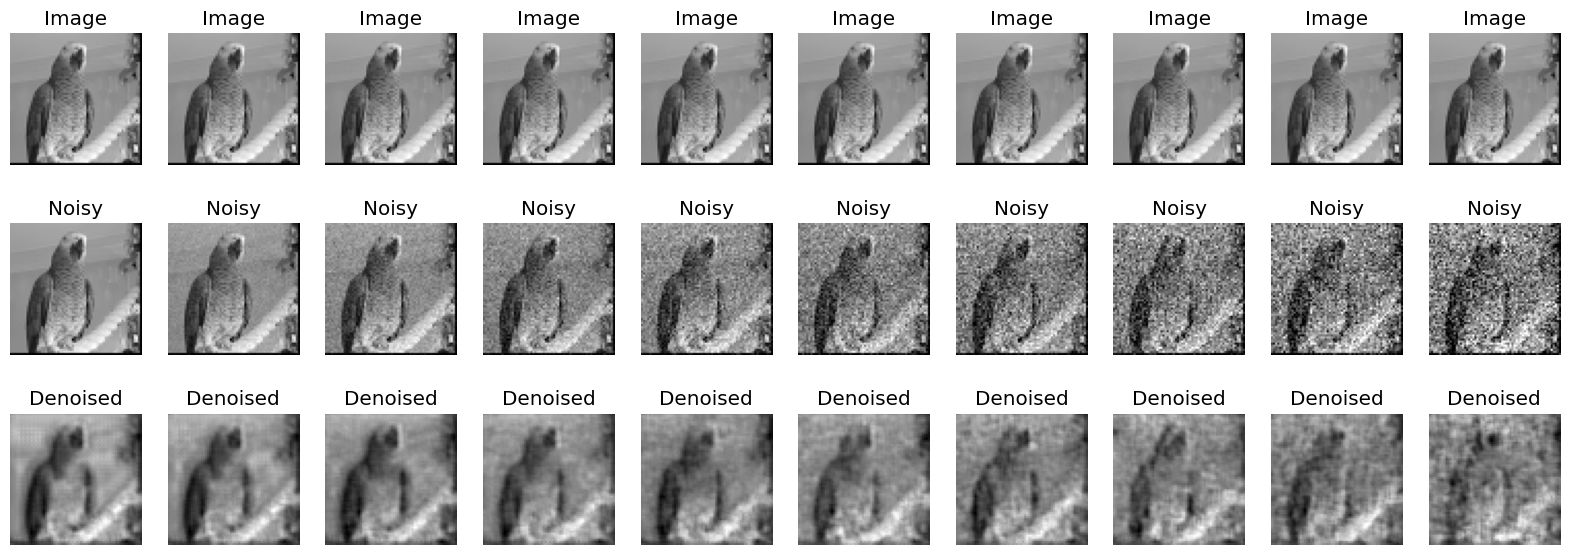

In [45]:
def get_noisy_img(img, sigma=60):
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_gray = img_gray
        noise = np.random.normal(0, sigma, img_gray.shape)
        img_noised = img_gray + noise
        return (img_gray/255.).astype(np.float32), (np.clip(img_noised, 0, 255)/255.).astype(np.float32)

img_path = "./data_denoising/test/00782.png"
img = cv.imread(img_path)[:, :, ::-1] 
sigmas = [i for i in range(0, 50, 5)]
noisy_img = []
restored_img = []

for sigma in sigmas : 

        img_gray, img_noisy = get_noisy_img(img, sigma=sigma)
        with torch.no_grad():
                # inference
                output, mean, logvar = model(torch.Tensor(img_noisy).to(device).unsqueeze(0).unsqueeze(0))
                noisy_img.append(img_noisy)
                restored_img.append(output.cpu().numpy())


plt.rcParams["figure.figsize"] = (20,7)
fig, axis = plt.subplots(3, 10)

for i, r_img in enumerate(restored_img):
        if i < 10:
            axis[0, i-10].imshow(img_gray, cmap='gray') 
            axis[0, i-10].set_title('Image')
            axis[0, i-10].axis('off')
            axis[1, i-10].imshow(noisy_img[i], cmap='gray')
            axis[1, i-10].set_title('Noisy')
            axis[1, i-10].axis('off')
            axis[2, i-10].imshow(restored_img[i].squeeze(0).squeeze(0), cmap='gray')
            axis[2, i-10].set_title('Denoised')
            axis[2, i-10].axis('off') 